In [15]:
import os
import glob
import json
import pandas as pd
import matplotlib.pyplot as plt

In [16]:
# Укажите путь к директории с JSON-файлами
json_dir = 'labeling_done'  # Замените на путь к вашим файлам

# Получаем список всех JSON-файлов в директории
json_files = glob.glob(os.path.join(json_dir, '*.json'))

data_list = []

for file in json_files:
    with open(file, 'r', encoding='utf-8') as f:
        try:
            data = json.load(f)
            # Если данные - список, добавляем все элементы, иначе - добавляем сам объект
            if isinstance(data, list):
                data_list.extend(data)
            elif isinstance(data, dict):
                data_list.append(data)
            else:
                print(f"Неизвестный формат в файле {file}")
        except json.JSONDecodeError as e:
            print(f"Ошибка декодирования JSON в файле {file}: {e}")

# Преобразуем список словарей в DataFrame
json_df = pd.DataFrame(data_list)

In [17]:
json_df

,origin,transcription,type
0,НАГЭС,нагэс,Звуковая аббревиатура
1,ЦУГАЗ,цуг+аз,Звуковая аббревиатура
2,ЕАПУ,еап+у,Звуковая аббревиатура
3,КУЭ,к+уэ,Звуковая аббревиатура
4,РМС,эр эм эс,Буквенная аббревиатура
...,...,...,...
3995,ТУДЭ,тудэ,Звуковая аббревиатура
3996,ЦБР,цэ бэ эр,Буквенная аббревиатура
3997,ННГМА,эн эн гэ эм а,Буквенная аббревиатура
3998,МНПЦ,эм эн пэ цэ,Буквенная аббревиатура


In [18]:
import pandas as pd

# Предполагаем, что DataFrame с данными из JSON уже создан и называется df_json
# Пример создания df_json:
# df_json = pd.DataFrame(data_list)

# Загрузка Excel-файла
excel_file_path = 'dataset\output_with_features.xlsx'  # Замените на путь к вашему Excel-файлу
df_excel = pd.read_excel(excel_file_path)

# Объединяем DataFrame-ы по колонкам: df_json['origin'] и df_excel['Аббревиатура']
# Параметр how='left' оставляет все строки из df_json, добавляя данные из Excel, если они есть
df = pd.merge(json_df, df_excel, left_on='origin', right_on='Аббревиатура', how='left')

In [19]:
df.drop(columns=['Аббревиатура', 'transcription', 'origin'], inplace=True)

In [20]:
df = df[df['type']!= 'Пропуск']
df = df[df['type']!= 'Буквенно-звуковая аббревиатура']
df = df[df['type']!= 'Другое']

In [21]:
df

,type,количество гласных,количество согласных,максимальное количество последовательных гласных,максимальное количество последовательных согласных,количество сочетаний ГC,количество сочетаний СГ,количество сочетаний ГСГ,количество сочетаний СГС,отношение гласных к согласным,первая буква,последняя буква
0,Звуковая аббревиатура,2,3,1,1,2,2,1,2,0.666667,С,С
1,Звуковая аббревиатура,2,3,1,1,2,2,1,2,0.666667,С,С
2,Звуковая аббревиатура,3,1,2,1,1,1,1,0,3.000000,Г,Г
3,Звуковая аббревиатура,2,1,2,1,0,1,0,0,2.000000,С,Г
4,Буквенная аббревиатура,0,3,0,3,0,0,0,0,0.000000,С,С
...,...,...,...,...,...,...,...,...,...,...,...,...
3995,Звуковая аббревиатура,2,2,1,1,1,2,1,1,1.000000,С,Г
3996,Буквенная аббревиатура,0,3,0,3,0,0,0,0,0.000000,С,С
3997,Буквенная аббревиатура,1,4,1,4,0,1,0,0,0.250000,С,Г
3998,Буквенная аббревиатура,0,4,0,4,0,0,0,0,0.000000,С,С


In [22]:
df.to_excel('output.xlsx', index=False)

In [23]:
import pandas as pd
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split, GridSearchCV,RandomizedSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTENC
from imblearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder

In [24]:
X = df.drop("type", axis=1)
y = df["type"]

In [25]:
# Преобразуем категориальные признаки в числовой формат (для SMOTENC)
categorical_features = ['первая буква', 'последняя буква']
for col in categorical_features:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col])

In [26]:
# Разделение данных на обучающую и тестовую выборки (80/20) с учетом стратификации
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [27]:
# Определяем индексы категориальных признаков для SMOTENC и CatBoost
cat_indices = [X_train.columns.get_loc(col) for col in categorical_features]

# # Создаем экземпляр SMOTENC с указанием индексов категориальных признаков
# # Устанавливаем k_neighbors=3, чтобы избежать ошибки, когда в некоторых фолдах слишком мало объектов
# smote_nc = SMOTENC(categorical_features=cat_indices, random_state=42, k_neighbors=3)

In [28]:
# Создаем Pipeline, который сначала выполняет балансировку, а затем обучает модель CatBoost
pipeline = Pipeline([
    # ('smote', smote_nc),
    ('catboost', CatBoostClassifier(
        loss_function='MultiClass',
        verbose=100,
        random_seed=42,
        cat_features=cat_indices  # передаем индексы категориальных признаков
    ))
])

In [29]:
# Определяем пространство параметров для поиска
param_grid = {
    # Количество итераций (итераций бустинга)
    'catboost__iterations': [500, 1000],
    
    # Максимальная глубина деревьев
    'catboost__depth': [4, 6, 8],
    
    # Скорость обучения (шаг градиентного бустинга)
    'catboost__learning_rate': [0.01, 0.05, 0.1],
    
    # Коэффициент L2-регуляризации (регуляризация листьев)
    'catboost__l2_leaf_reg': [1, 3, 5],
    
    # Степень случайности при выборе сплитов
    'catboost__random_strength': [1, 2, 5],
    
    # «Температура» для стохастического бустинга (при bootstrap_type='Bayesian')
    'catboost__bagging_temperature': [0, 1, 3]
}

In [30]:
# Запускаем поиск лучших параметров с помощью GridSearchCV (4-fold CV, оценка по accuracy)
grid = RandomizedSearchCV(pipeline, param_grid, cv=4, scoring='accuracy', n_jobs=-1, random_state=42, n_iter=15)
grid.fit(X_train, y_train)

print("Лучшие параметры: ")
display(grid.best_params_)

c:\Users\admin\Desktop\abver_learn\venv\Lib\site-packages\sklearn\model_selection\_validation.py:528: FitFailedWarning: 
15 fits failed out of a total of 60.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
15 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\admin\Desktop\abver_learn\venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\admin\Desktop\abver_learn\venv\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\admin\Desktop\abver_learn\venv\Lib\site-packages\imblearn

0:	learn: 0.6861257	total: 135ms	remaining: 1m 7s
100:	learn: 0.3525847	total: 232ms	remaining: 916ms
200:	learn: 0.2679543	total: 324ms	remaining: 482ms
300:	learn: 0.2403019	total: 415ms	remaining: 274ms
400:	learn: 0.2296671	total: 508ms	remaining: 125ms
499:	learn: 0.2252651	total: 600ms	remaining: 0us
Лучшие параметры: 


{'catboost__random_strength': 1,
 'catboost__learning_rate': 0.01,
 'catboost__l2_leaf_reg': 3,
 'catboost__iterations': 500,
 'catboost__depth': 4,
 'catboost__bagging_temperature': 0}

In [31]:
# Обучаем лучшую модель на обучающей выборке (на самом деле, GridSearchCV уже обучил её)
best_model = grid.best_estimator_

# Предсказываем классы на тестовой выборке
y_pred = best_model.predict(X_test)

In [32]:
# Вычисляем метрики
accuracy = accuracy_score(y_test, y_pred)
print("Test Accuracy: ")
display(accuracy)
print("Classification Report:")
report = classification_report(y_test, y_pred, output_dict=True)
df_report = pd.DataFrame(report).transpose()
df_report = df_report.rename(index={'accuracy': 'overall accuracy'})
display(df_report)

Test Accuracy: 


0.9016817593790427

Classification Report:


,precision,recall,f1-score,support
Буквенная аббревиатура,0.922607,0.922607,0.922607,491.000000
Звуковая аббревиатура,0.865248,0.865248,0.865248,282.000000
overall accuracy,0.901682,0.901682,0.901682,0.901682
macro avg,0.893928,0.893928,0.893928,773.000000
weighted avg,0.901682,0.901682,0.901682,773.000000


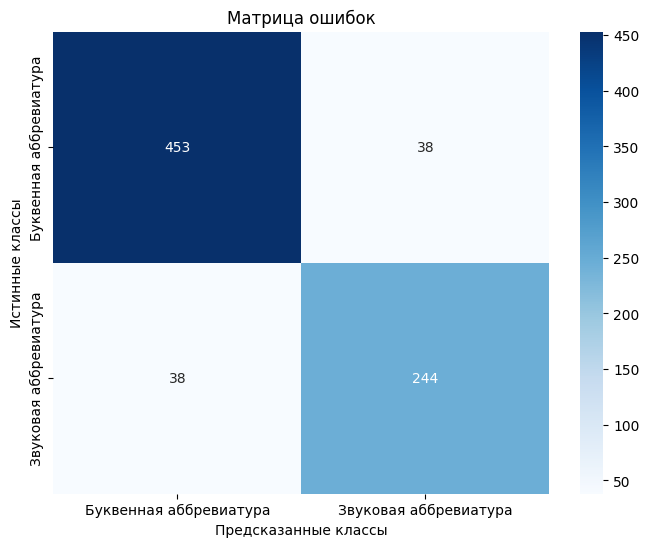

In [33]:
# Строим матрицу ошибок
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
            xticklabels=best_model.named_steps['catboost'].classes_,
            yticklabels=best_model.named_steps['catboost'].classes_)
plt.xlabel("Предсказанные классы")
plt.ylabel("Истинные классы")
plt.title("Матрица ошибок")
plt.show()

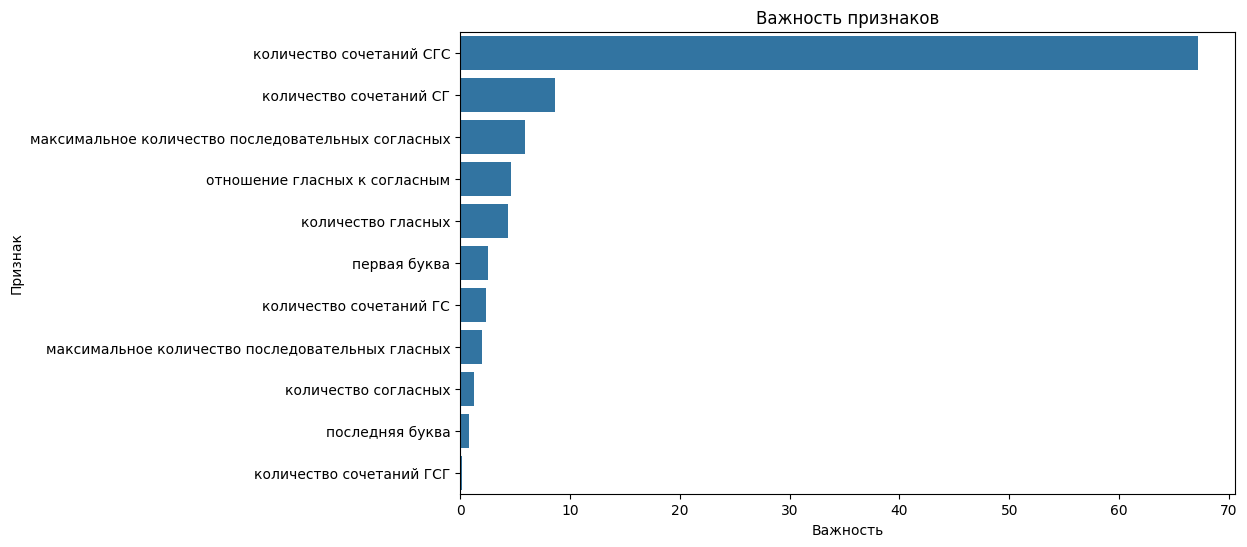

In [34]:
# Визуализация важности признаков от CatBoost
feature_importances = best_model.named_steps['catboost'].get_feature_importance()
features = X_train.columns
fi_df = pd.DataFrame({"feature": features, "importance": feature_importances})
fi_df.sort_values("importance", ascending=False, inplace=True)

plt.figure(figsize=(10, 6))
sns.barplot(x="importance", y="feature", data=fi_df)
plt.title("Важность признаков")
plt.xlabel("Важность")
plt.ylabel("Признак")
plt.show()
